# Structural Imbalance with the D-Wave System
In the [Leap](https://cloud.dwavesys.com/leap) structural imbalance demo, you saw how Juliet’s new love of Romeo introduced imbalance into the social network of Verona.   
<img src="images/Romeo.png" width=250x/>

This notebook examines how you can solve optimization problems on a  D-Wave quantum processing unit (QPU) with the example of a structural imbalance problem.

1. [What is Structural Imbalance?](#What-is-Structural-Imbalance?) defines and explains the structural imbalance problem.
2. [Formulating the Problem](#Formulating-the-Problem-for-a-D-Wave-System) shows how such optimization problems can be formulated for solution on a quantum computer. 
3. [A Toy Example](#A-Toy-Example) codes a small structural imbalance problem to demonstrate the solution technique. 
3. [A Real-World Example](#A-Real-World-Example) applies the solution to the data sets of the Stanford Militants Mapping Project.

This notebook should help you understand both the techniques and [Ocean software](https://github.com/dwavesystems) tools used for solving optimization problems on D-Wave quantum computers.

**New to Jupyter Notebooks?** JNs are divided into text or code cells. Pressing the **Run** button in the menu bar moves to the next cell. Code cells are marked by an "In: \[\]" to the left; when run, an asterisk displays until code completion: "In: \[\*\]".

# What is Structural Imbalance?
*Social networks* map relationships between people or organizations onto graphs, with
the people/organizations as nodes and relationships as edges; for example,
friends form a social network. *Signed social networks* map both friendly and
hostile relationships by assigning to edges either positive or negative values. Such networks are said to be *structurally balanced* when they can be cleanly divided into two sets, with each set containing only friends, and all relations between these sets are hostile. The measure of *structural imbalance* or *frustration* for a signed social network, when it cannot be cleanly divided, is the minimum number of edges that violate the social rule, “the enemy of my friend is my enemy.”

Finding a division that minimizes frustration is an NP-hard graph problem (it can be viewed as an expansion of the well-known [maximum cut](https://en.wikipedia.org/wiki/Maximum_cut) problem). This is an example of a broad class of optimization problems well-suited to solution on D-Wave systems. Other [examples](https://docs.dwavesys.com/docs/latest/c_handbook_2.html) include protein folding, traffic flow optimization, job-shop scheduling, and many more.  

# Formulating the Problem for a D-Wave System
How can you formulate this problem for a D-Wave quantum computer to solve? 

D-Wave systems solve [Ising](#https://en.wikipedia.org/wiki/Ising_model) problems: given $N$ variables $s_1,...,s_N$, where each variable $s_i$ can have values $-1$ or $+1$, the system finds assignments of values that minimize 

  $\sum_{i=1}^N h_i s_i +
  \sum_{i<j}^N J_{i,j} s_i s_j$,

where $h_i$ and $J_{i,j}$ are configurable (linear and quadratic) coefficients. To formulate a problem for the D-Wave system is to program $h_i$ and $J_{i,j}$ so that assignments of $s_1, ..., s_N$ that minimize this summation also represent solutions to the problem. 

In this case, variables $s_i$ can represent people, with values $-1,+1$ denoting a person's assignment to one of the two sets you want to divide the social network into. If you set $J_{i,j}$ to $-1$ for friendly $s_is_j$ pairs and $+1$ for hostile pairs, their multiplication takes values

$J_{i,j} s_i s_j=
\begin{cases} 
      -1 & \text{friends in same set (} s_i=s_j \text{) or enemies in different sets ($s_i \ne s_j$)} \\
      +1 & \text{friends in different sets ($s_i \ne s_j$) or enemies in same set ($s_i=s_j$)} 
\end{cases}
$

The summation $\sum_{i<j}^N J_{i,j} s_i s_j$ now decrements when an assignment contributes to balance and increments when it contributes to frustration.

You can see this in the graphic below, which shows all possible combinations of a two-nodes signed social network. People in the $-1$ set are shown as yellow dots, the $+1$ set as blue dots. Friendly relationships are shown as green edges, hostile as red. 

<img src="images/TwoNodes_AllCombinations.png" width=450x/>

If you set $h_i=0$, the Ising model is just $\sum_{i<j}^N J_{i,j} s_i s_j$. Programmed with these coefficients for a given signed social network, the quantum computer finds partitions (assignments of $s_i$) that minimize frustration. 

This is an example of a technique called a *penalty model*, where a problem is formulated so that undesired outcomes are penalized by being assigned higher values in the term being minimized. D-Wave [documentation](https://docs.dwavesys.com/docs/latest/doc_getting_started.html) describes this and various other techniques for formulating optimization problems for solution on the quantum computer.

## A Toy Example

The code in this section demonstrates the use of [Ocean software](https://docs.ocean.dwavesys.com/en/stable/index.html) on a small social network. The next section implements the solution on a real-world problem. 

The first code cell creates a $K_4$ [complete](https://en.wikipedia.org/wiki/Complete_graph) social graph (each one of four people is connected to the other three) using the [NetworkX](https://networkx.github.io/) `complete_graph` function. Relationships between the four are set randomly to friend or enemy each time you execute the code (by pressing the **Run** button with your mouse in the cell--try it a few times). 

In [3]:
import networkx as nx
import random

G = nx.complete_graph(4)

# Randomly assign +1 or -1 relationship signs to all edges. Rename node 0 to Alice, 1 to Bob, etc
G.add_edges_from([(u, v, {'sign': 2*random.randint(0, 1) - 1}) for u, v in G.edges])
nx.relabel_nodes(G, {0: 'Alice', 1: 'Bob', 2: 'Eve', 3: 'Wally'}, copy=False)

print('Friendly relationships: \n\t' + '\n\t'.join(list(x + " & " + y for (x, y, sign) in G.edges(data='sign') if (sign == 1))))
print('Hostile relationships: \n\t' + '\n\t'.join(list(x + " & " + y for (x, y, sign) in G.edges(data='sign') if (sign == -1))))

Friendly relationships: 
	Alice & Bob
	Alice & Eve
	Bob & Wally
Hostile relationships: 
	Alice & Wally
	Bob & Eve
	Eve & Wally


### Setting Up a Solver
Set up a D-Wave system as your solver in the standard way described in the Ocean documentation's [Using a D-Wave System](https://docs.ocean.dwavesys.com/en/stable/overview/dwavesys.html). 

The cell sets a *sampler*, the component used to find variable values that minimize the Ising model representing our problem. Here we use a D-Wave system, but Ocean tools are designed to swap in and out samplers with ease. For example you might first run a classical sampler on your computer's CPU during testing, and only once your code is ready, submit the problem for solution on the quantum computer.   

`DWaveSampler()` from Ocean software's [dwave-system](https://docs.ocean.dwavesys.com/projects/system/en/stable/) tool handles the connection to a D-Wave system. This tool also handles mapping between the graph of our problem, NetworkX's `complete_graph(4)` graph with nodes labeled Alice, Bob etc, to the D-Wave QPU's numerically indexed qubits. This mapping, known as *minor-embedding*, is done by the `EmbeddingComposite()` composite.   

In [4]:
# from dwave.system import DWaveSampler, EmbeddingComposite

# sampler = EmbeddingComposite(DWaveSampler())

from dwave.samplers import SimulatedAnnealingSampler
sampler = SimulatedAnnealingSampler()

### Solving the Problem
Next, the `structural_imbalance` algorithm, from Ocean's [dwave_networkx](https://docs.ocean.dwavesys.com/en/stable/docs_dnx/sdk_index.html) extension of the NetworkX graphic package, submits the Ising model you formulated in the previous section to a D-Wave system. It returns a partition of the social network into two colored sets and the frustrated edges.

In [5]:
import dwave_networkx as dnx

imbalance, bicoloring = dnx.structural_imbalance(G, sampler)

# Mark on the graph the returned frustrated edges and node set (color)  
for edge in G.edges:
    G.edges[edge]['frustrated'] = edge in imbalance
for node in G.nodes:
    G.nodes[node]['color'] = bicoloring[node]

print('Yellow set: \n\t' + '\n\t'.join(list(person for (person, color) in bicoloring.items() if (color == 0))))
print('Blue set: \n\t' + '\n\t'.join(list(person for (person, color) in bicoloring.items() if (color == 1))))
print('Frustrated relationships: \n\t' + '\n\t'.join(list(x + " & " + y for (x, y) in imbalance.keys())))

Yellow set: 
	Alice
	Eve
Blue set: 
	Bob
	Wally
Frustrated relationships: 
	Alice & Bob


Display the solution using a `draw` function that represents friendly interactions as green lines, hostile interactions as red lines, and frustration as dashed lines.

<div class="alert alert-warning" role="alert" style="margin: 10px">Note: The code cell below imports from <code>helpers</code>, a folder colocated with this Jupyter Notebook. Users running it in <a href="https://cloud.dwavesys.com/leap">Leap</a> can see helper functions by selecting <i>Jupyter File Explorer View</i> on the <i>Online Learning</i> page.</div>

In [6]:
%matplotlib inline

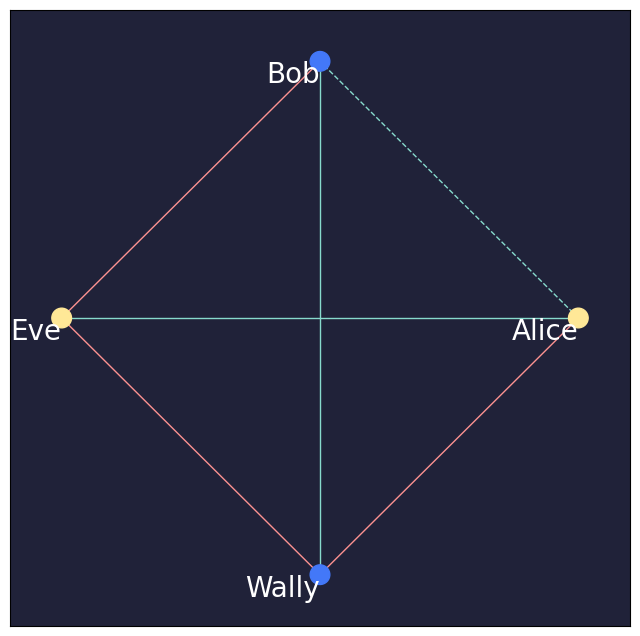

In [7]:
import matplotlib.pyplot as plt

# For better performance in a VS Code environment, such as Leap's IDE, change to "%matplotlib inline"
# %matplotlib ipympl     

from helpers.draw import draw

draw(G, with_labels=True);

You can rerun the cells of this section to produce different random relationships and display different imbalances.

The steps used in this section can solve the structural imbalance problem for other signed social networks. Some coding is needed to load the social network into a NetworkX graph with signed edges, which is standard software work of converting data between formats. 

# A Real-World Example
Next, expand to the large data sets of [Mapping Militant Organizations, Stanford University, last modified February 28, 2016, http://web.stanford.edu/group/mappingmilitants/cgi-bin/](http://web.stanford.edu/group/mappingmilitants/cgi-bin/). Load data saved from the Stanford Militants Mapping Project into NetworkX graph. 

In [8]:
from helpers.loader import global_signed_social_network

G = global_signed_social_network()

First, calculate imbalance on a selected region and time period, Syria 2013, by filtering on these attributes of the data now in graph G.

In [9]:
# Select the Syria subregion 
syria_groups = set()
for v, data in G.nodes(data=True):
    if 'map' not in data:
        continue
    if data['map'] in {'Syria', 'Aleppo'}:
        syria_groups.add(v)
S = G.subgraph(syria_groups)

# Filter by year
year = 2013
filtered_edges = ((u, v) for u, v, a in S.edges(data=True) if a['event_year'] <= year)
S = S.edge_subgraph(filtered_edges)

The resulting graph has nodes representing militant groups, with indexical labels, and edges with a "sign" attribute marking friendly or hostile relationships.

Show data associated with the first two nodes and edges:

In [10]:
print(list(S.nodes(data=True))[:2])
print(list(S.edges(data=True))[:2])

[(1, {'map': 'Aleppo'}), (523, {'map': 'Aleppo'})]
[(1, 661, {'sign': -1, 'event_id': '1865', 'event_type': 'riv', 'event_year': 2011, 'event_description': 'Jaysh al Sanadeed began targeting the Islamic State.'}), (1, 523, {'sign': 1, 'event_id': '1821', 'event_type': 'all', 'event_year': 2013, 'event_description': 'Ahrar al-Sham and the Islamic State coordinated an attack on Alawite villages in the Latakia governorate that killed 190 civilians.'})]


Display the network using the `draw` function that represents friendly interactions as green lines, hostile interactions as red lines. Move your mouse over edges to see attributes.

Note: In a VS Code environment, such as Leap's IDE, if you changed to ``%matplotlib inline`` above for better performance, graphs are not interactive.

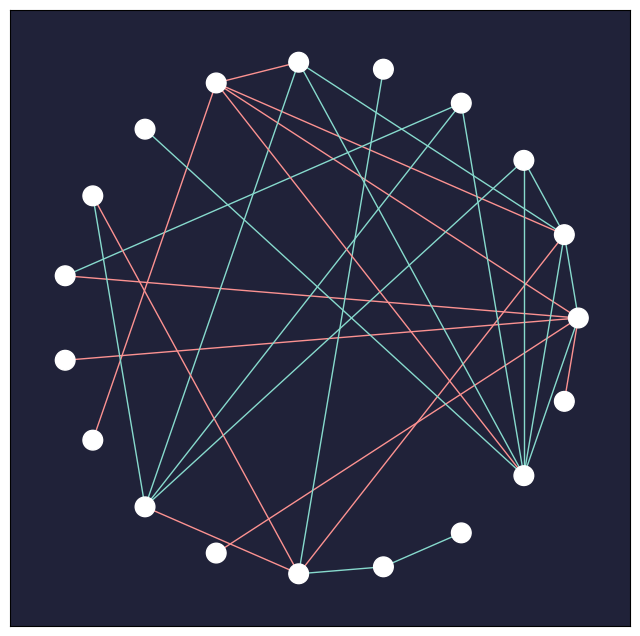

In [11]:
position = draw(S)

As in the previous section, Ocean suite's *dwave_networkx* calculates the frustration of the network on a D-Wave system, this time on the Syrian 2013 network. 

In [12]:
imbalance, bicoloring = dnx.structural_imbalance(S, sampler)

for edge in S.edges:
    S.edges[edge]['frustrated'] = edge in imbalance
for node in S.nodes:
    S.nodes[node]['color'] = bicoloring[node]

See the updates made to the graph:

In [13]:
print(list(S.nodes(data=True))[:2])
print(list(S.edges(data=True))[:2])

[(1, {'map': 'Aleppo', 'color': np.int8(0)}), (523, {'map': 'Aleppo', 'color': np.int8(0)})]
[(1, 661, {'sign': -1, 'event_id': '1865', 'event_type': 'riv', 'event_year': 2011, 'event_description': 'Jaysh al Sanadeed began targeting the Islamic State.', 'frustrated': False}), (1, 523, {'sign': 1, 'event_id': '1821', 'event_type': 'all', 'event_year': 2013, 'event_description': 'Ahrar al-Sham and the Islamic State coordinated an attack on Alawite villages in the Latakia governorate that killed 190 civilians.', 'frustrated': False})]


Redraw the network with the previous node positioning: nodes are now bicolored and dashed lines indicate frustrated edges.

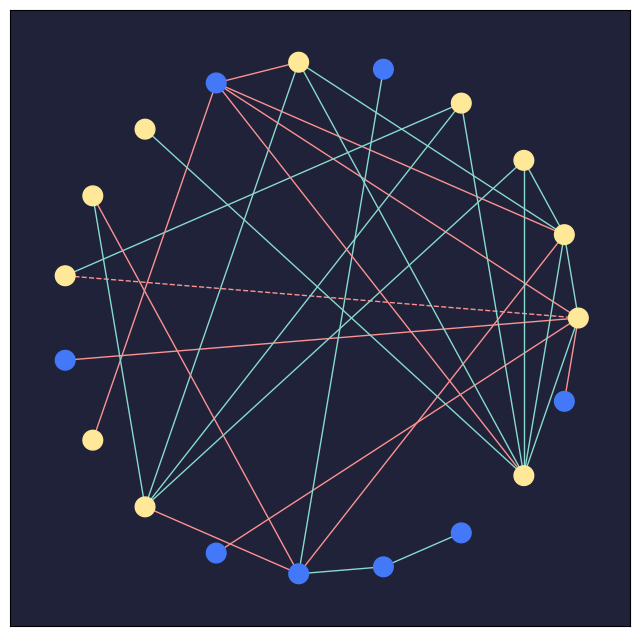

In [14]:
draw(S, position);

Redraw the network with a new positioning that separates the two sets.

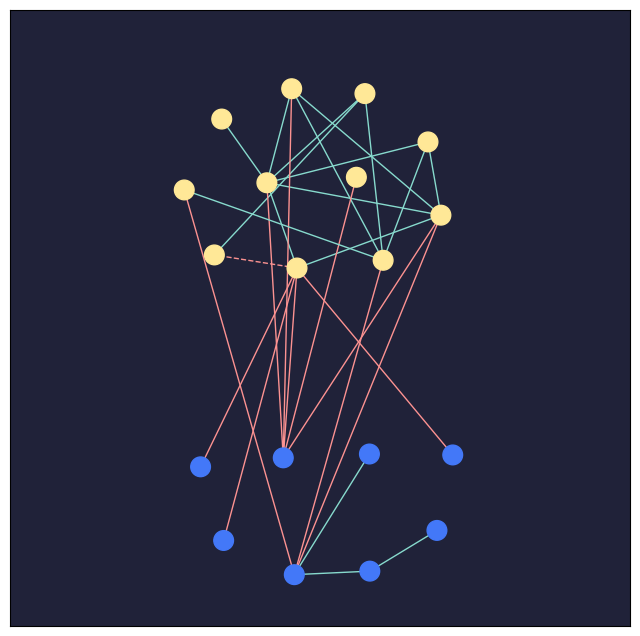

In [15]:
draw(S);

# Summary
Structural imbalance for social networks is a problem well suited for solving on the D-Wave system: unlike factoring, where typically large integer variables must be converted to even larger binary variables, this problem's structure of bi-valued variables in a typically sparse graph of quadratic relationships is close to a native Ising problem.

You saw how to mathematically formulate an Ising model to represent this problem with the technique of a penalty model, which is used to solve a wide variety of optimization problems on the quantum computer. You then used Ocean tools to formulate the problem and submit it for solution.   

Finally, the following cell attempts to calculate structural imbalance on the entire saved data set from the Stanford Militants Mapping Project, which has over 200 variables. Consider the following:

* The heuristic minor-embedding used by this code might not reliably represent such a large problem, and consequently solutions might not be optimal. Embedding such problems requires more advanced techniques that are beyond the scope of this demo.  
* A simple alternative to submitting problems this large (or much larger) directly to the QPU is to use a quantum-classical hybrid solver, as discussed in the [Leap](https://cloud.dwavesys.com/leap) *Hybrid Computing* Jupyter Notebooks.

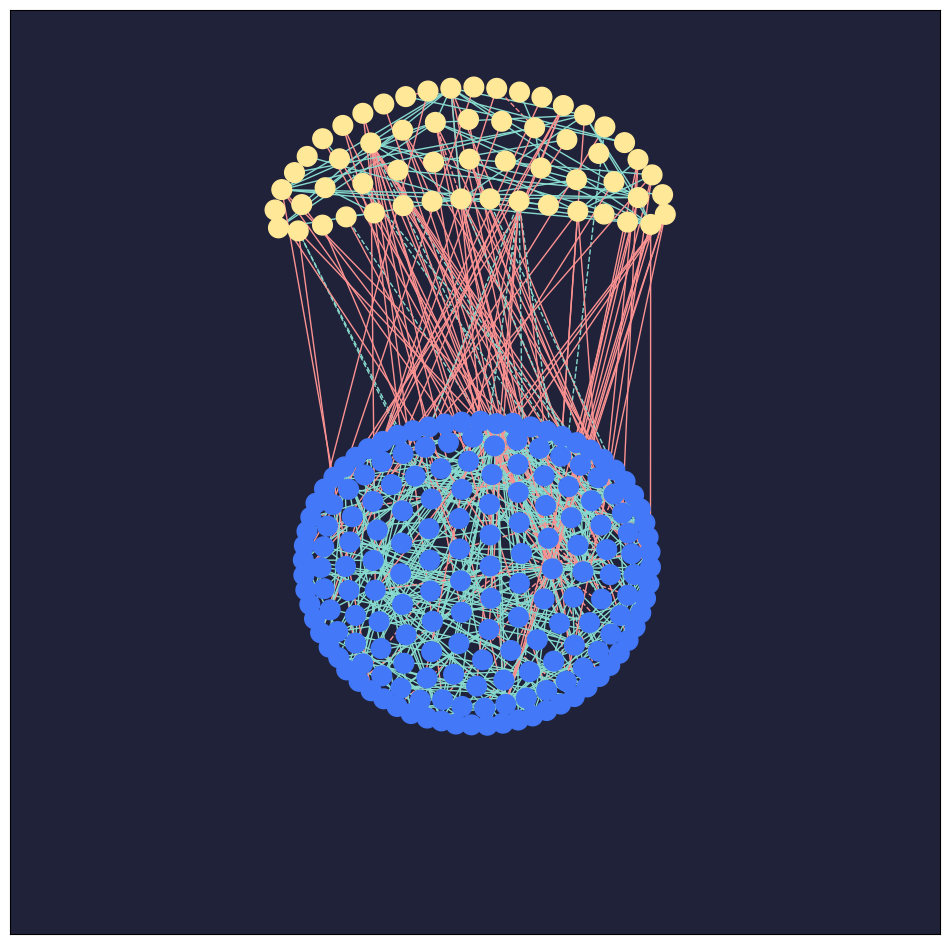

In [16]:
imbalance, bicoloring = dnx.structural_imbalance(G, sampler)

for edge in G.edges:
    G.edges[edge]['frustrated'] = edge in imbalance
for node in G.nodes:
    G.nodes[node]['color'] = bicoloring[node]
draw(G);

For one particular submission to an Advantage quantum computer, the minor-embedding for the entire saved database (238 variables) represented one variable with a dozen qubits coupled strongly together (a [chain](https://docs.ocean.dwavesys.com/en/stable/concepts/embedding.html) of qubits). Chains are used when minor-embedding any but the smallest problems; however, such long chains can be unreliable and affect performance. 

Ocean software's [problem inspector](https://docs.ocean.dwavesys.com/en/stable/docs_inspector/sdk_index.html) tool shows the embedded problem, highlighting the long chain: 

<img src="images/EmbeddingFullDB_inspector.png" width="700px"/>

[Ocean software](https://github.com/dwavesystems) provides tools for formulating many types of problems for solution on a QPU and the [Ocean documentation](https://docs.ocean.dwavesys.com/en/stable) and [system documentation](https://docs.dwavesys.com/docs/latest/index.html) describe various techniques for formulating problems.    

Copyright &copy; 2020 D-Wave Systems, Inc

The software is licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This Jupyter Notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>